# We analyse multiple trajectories for a smooth landscape with one hidden units, high learning rate and then characterize the diffusion - BUT here we use all the roatated versions of each configuration.

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [6]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/18_singleUnit_Diffusion_symmetricTraining')

In [ ]:
#import dill
#dill.load_session('./data_bruckner/data/notebookData/18_singleUnit_Diffusion_symmetricTraining')

In [89]:
Num_reps=10

In [88]:
N = 100
beta = 1.
Num_configs = 10000

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Spin')

#Define Couplings
BM.layer.couplings =  beta* (np.eye(N=N,k=1) + np.eye(N=N,k=-1) )
BM.layer.couplings[0,-1] += beta
BM.layer.couplings[-1,0] += beta

data = np.zeros([Num_configs,N])
data_master = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs/N,Nstep=200) # N steps.

# Rotate each configuration all the unique times possible and then do the same for a new configuration

k=0
for i in range(Num_configs/N):
    for j in range(N):
        data[k] = np.roll(data_master[i],j)
        k = k+1

In [ ]:
#data_big    = []
results_big = []
RBM_big     = []
weights     = np.zeros([Num_reps,Num_configs*100/(100*1000),100])

for i in np.arange(Num_reps):
    
    #Train the model
    RBM = rbm.RBM(visible = 'Spin', n_v=N, n_h = 1, hidden = 'Spin',zero_field = True)
    results = RBM.fit(data,n_iter=100,verbose=0,learning_rate = 0.1,record=['W'],record_interval=1000,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False);
    
    weights[i,:,:] = np.array(results['W'])[:,0,:]
    
    results_big.append(results)
    RBM_big.append(RBM)
    
    del results
    del RBM
    
    print i

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

Starting epoch 58
Starting epoch 59
Starting epoch 60
Starting epoch 61
Starting epoch 62
Starting epoch 63
Starting epoch 64
Starting epoch 65
Starting epoch 66
Starting epoch 67
Starting epoch 68
Starting epoch 69
Starting epoch 70
Starting epoch 71
Starting epoch 72
Starting epoch 73
Starting epoch 74
Starting epoch 75
Starting epoch 76
Starting epoch 77
Starting epoch 78
Starting epoch 79
Starting epoch 80
Starting epoch 81
Starting epoch 82
Starting epoch 83
Starting epoch 84
Starting epoch 85
Starting epoch 86
Starting epoch 87
Starting epoch 88
Starting epoch 89
Starting epoch 90
Starting epoch 91
Starting epoch 92
Starting epoch 93
Starting epoch 94
Starting epoch 95
Starting epoch 96
Starting epoch 97
Starting epoch 98
Starting epoch 99
Starting epoch 100
4
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 1

Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
Starting epoch 57
Starting epoch 58
Starting epoch 59
Starting epoch 60
Starting epoch 61
Starting epoch 62
Starting epoch 63
Starting epoch 64
Starting epoch 65
Starting epoch 66
Starting epoch 67
Starting epoch 68
Starting epoch 69
Starting e

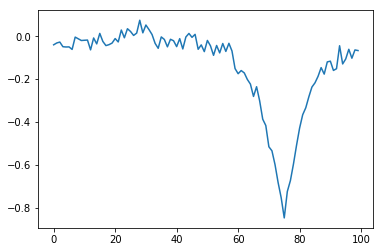

In [22]:
plt.plot(weights[0,-10])

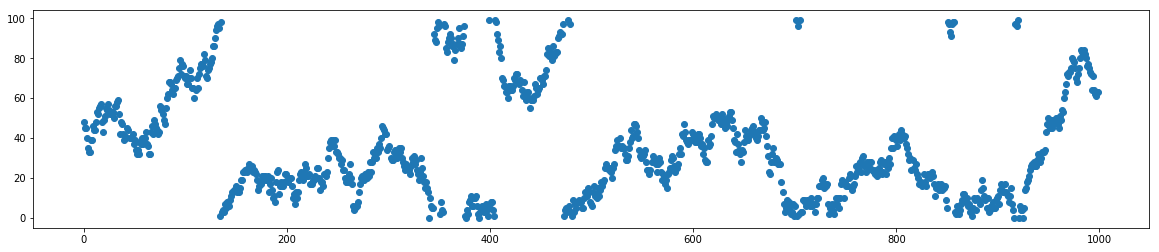

In [24]:
plt.figure(figsize=(20,4))
plt.plot(np.arange(Num_configs*100/(100*1000)),np.argmax(abs(weights[0]),axis=1),'o')

### Manual correction due to Periodic Boundary Conditions - If the position moves through the boundary, add or subtract the boundary value to it

In [80]:
def PBC_corr(peakCentre):
    for i in np.argwhere(abs(peakCentre-np.roll(peakCentre,1))>50):
        if peakCentre[int(i)]<15:
            peakCentre[int(i):] += + 100
        elif peakCentre[int(i)]>85:
            peakCentre[int(i):] += - 100
    return peakCentre

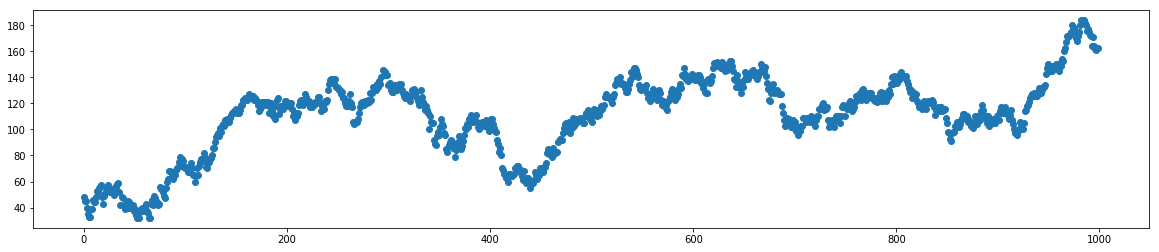

In [81]:
peakCentre_PBC = PBC_corr(peakCentre)
plt.figure(figsize=(20,4))
plt.plot(np.arange(Num_configs*100/(100*1000)),peakCentre_PBC,'o')

### Diffusion (MSD) analysis for this peak:

In [82]:
MSD = np.zeros([len(peakCentre_PBC)/2,1])
for i in np.arange(len(peakCentre)/2):
    MSD[i,0] = (np.sum((peakCentre_PBC - np.roll(peakCentre_PBC,i))**2))/(len(peakCentre_PBC))
#linear_coeff = np.polyfit(np.arange(2500/2),MSD,1)

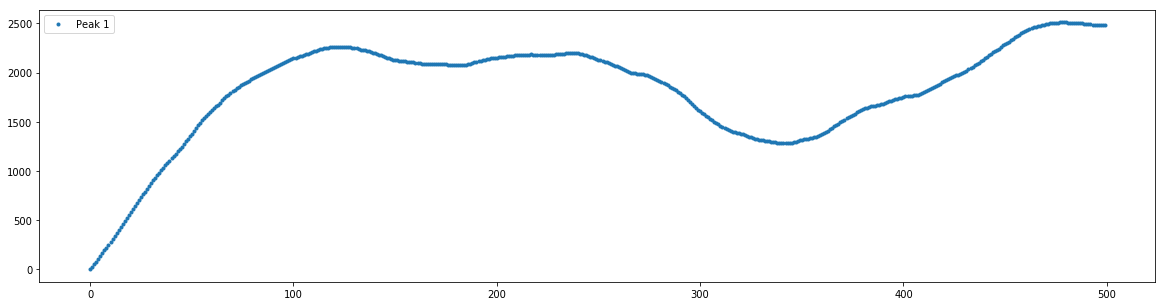

In [83]:
plt.figure(figsize=(20,5))
plt.scatter(np.arange(len(MSD)),MSD[:,0], marker='.',label = 'Peak 1')
#plt.ylabel('Centre of Mass of the peaks')
plt.legend()

## Increased Learning Rate

In [ ]:
RBM2 = rbm.RBM(visible = 'Spin', n_v=N, n_h = 1, hidden = 'Spin',zero_field = True)
results2 = RBM2.fit(data1,n_iter=100,verbose=0,learning_rate = 1.0,record=['W'],record_interval=1000,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False);

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10


In [87]:
RBM1 = np.copy(RBM_big[0])
results1 = np.copy(results_big[0])
data1 = np.copy(data)
weights1 = np.copy(weights)